# Episode 47. Neural Network With PyTorch

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset

## Define Dataset Class
'''
In PyTorch, it is common to define a class that loads csv data
'''

In [2]:
class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0] # 0-9 digit
        target = torch.zeros((10)) # one-hot indicator for label (0-9)
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass


## Load MNIST Data

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [4]:
mnist_train = MnistDataset('mount/My Drive/Colab Notebooks/mnist_train.csv')

In [ ]:
# Dataset class contains "label, image values and target tensor"
idx = 0 # choose a row
mnist_train[idx]

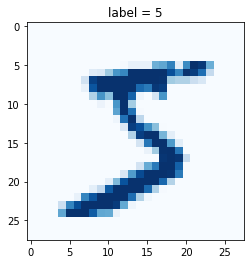

In [7]:
# plot images
mnist_train.plot_image(idx)

## Define Neural Network Class
'''
In PyTorch, neural networks are usually defined as a class
'''

In [22]:
# Network class

class Network(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers: Sequential Method
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 10),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # Update
        self.optimiser.zero_grad() # reset gradients to zero (erase previous iteration's gradients)
        loss.backward() # compute gradients in network 9backpropagation)
        self.optimiser.step() # update network weights

        pass
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

## Train Neural Network

In [ ]:
%%time 
# create neural network
NN = Network()

# train network on MNIST training data
epochs = 4

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_train:
        NN.train(image_data_tensor, target_tensor)
        pass
    pass

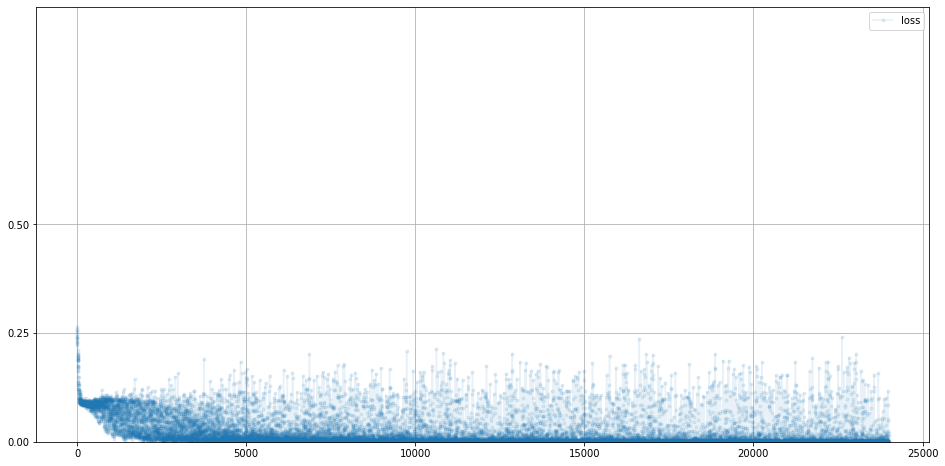

In [15]:
# plot losses during training
NN.plot_progress()

## Verify Trained Network Using Test Data

### Load Test Data

In [16]:
# load MNIST test data
mnist_test = MnistDataset('mount/My Drive/Colab Notebooks/mnist_test.csv')

### (1) pick a test observation: show true label & image

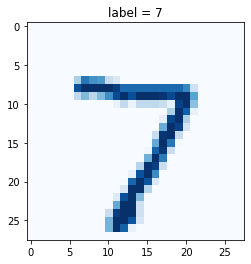

In [31]:
idx = 0 # choose a row
# plot image and True label
mnist_test.plot_image(idx)

### (2) Show predicted on-hot indicators (bar graph)

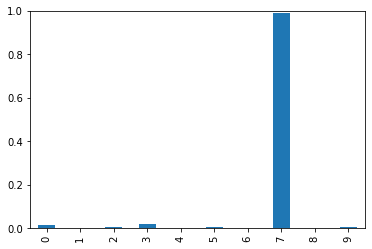

In [18]:
# visualise the answer given by the neural network
image_data = mnist_test[idx][1]

# query from trained network
output = NN.forward(image_data)

# plot predicted output (10 one-hot indicators)
pd.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

## Check Overall Training Performance (Using Test Data)

In [30]:
# test trained neural network on training data
ncorrect = 0
ntotal = 0
for label, image_data_tensor, target_tensor in mnist_test:
    answer = NN.forward(image_data_tensor).detach().numpy()
    if (answer.argmax() == label): # network perdicted label matches with true label?
        ncorrect += 1
        pass
    ntotal += 1
    
    pass

print("Accuracy:", 100*ncorrect/ntotal,"%", "( # Correct:", ncorrect, "and # Total:", ntotal,")")

Accuracy= 92.91 % ( # Correct: 9291 and  # Total: 10000 )
